# Convolutions and FFT

A [convolution](https://en.wikipedia.org/wiki/Convolution) is a linear operator of the form
\begin{equation}
(f \ast g)(t) = \int f(\tau) g(t - \tau ) d\tau
\end{equation}
In a discrete space, this turns into a sum
\begin{equation}
\sum_\tau f(\tau) g(t - \tau)
\end{equation}

Convolutions are *shift invariant*, or *time invariant*.  They frequently appear in temporal and spatial image processing, as well as in probability.

If we want to represent the discrete convolution operator as a matrix, we get a *toeplitz matrix* $G$
\begin{equation}
G = \begin{bmatrix}
g(0) & g(1) & g(2) & \dots\\
g(-1) & g(0) & g(1) &\dots\\
g(-2) & g(-1) & g(0) & \dots\\
\vdots & & &\ddots
\end{bmatrix}
\end{equation}

A circulant matrix acting on a discrete signal of length $N$ is a toeplitz matrix where $g(-i) = g(N-i)$.

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg as la
import matplotlib.pyplot as plt

In [2]:
c = np.arange(0,-4, -1) # first column
r = np.arange(4) # first row
la.toeplitz(c, r)

array([[ 0,  1,  2,  3],
       [-1,  0,  1,  2],
       [-2, -1,  0,  1],
       [-3, -2, -1,  0]])

In [3]:
c = np.arange(4)
la.circulant(c)

array([[0, 3, 2, 1],
       [1, 0, 3, 2],
       [2, 1, 0, 3],
       [3, 2, 1, 0]])

both toeplitz and circulant matrices have special `solve` function in `scipy.linalg`

In [4]:
N = 100
c = np.random.randn(N)
r = np.random.randn(N)
A = la.toeplitz(c, r)

x = np.random.rand(N)

print("standard solve")
%time y1 = la.solve(A, x)

print("\ntoeplitz solve")
%time y2 = la.solve_toeplitz((c,r), x)

print(la.norm(y1- y2))

standard solve
CPU times: user 4.81 ms, sys: 327 µs, total: 5.14 ms
Wall time: 16.4 ms

toeplitz solve
CPU times: user 185 µs, sys: 0 ns, total: 185 µs
Wall time: 183 µs
2.198426408026534e-12


In [5]:
N = 100
c = np.random.randn(N)
A = la.circulant(c)

x = np.random.randn(N)

print("standard solve")
%time y1 = la.solve(A, x)

print("\ncirculant solve")
%time y2 = la.solve_circulant(c, x)

print(la.norm(y1- y2))

standard solve
CPU times: user 2.64 ms, sys: 841 µs, total: 3.48 ms
Wall time: 2.14 ms

circulant solve
CPU times: user 1.21 ms, sys: 26 µs, total: 1.24 ms
Wall time: 1 ms
9.948874962446294e-15


### Example

One place where convolutions appear is in combining probability distributions.  For instance, if we take a sample $x \sim y + z$ where $y \sim f$ and $z \sim g$ and $f, g$ are probability density functions, then the probability density function that describes the random variable $x$ is $f\ast g$.

## Fourier Transforms

A [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) takes functions back and forth between time and frequency domains.
\begin{equation}
\hat{f}(\omega) = \int_{-\infty}^\infty f(x) e^{-2\pi i x \omega} dx
\end{equation}

In practice, Fourier transforms are often computed using the Fast Fourier Transform (FFT) algorithm, which runs in $O(N\log N)$ time for a signal of length $N$.  Scipy provides funcitons for FFT as well as the inverse iFFT.


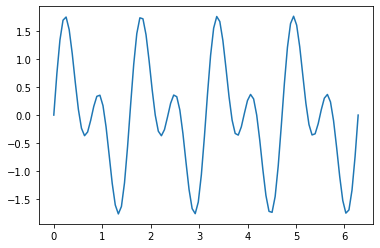

In [6]:
from scipy.fft import fft, ifft

x = np.linspace(0, 2*np.pi, 100)
f = np.sin(4*x) + np.sin(8*x)
plt.plot(x, f)
plt.show()

the function in frequency space typically has real and imaginary components.

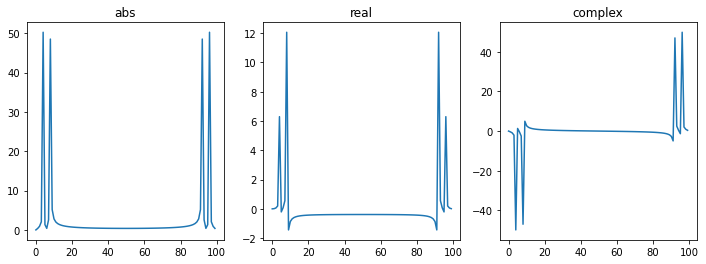

In [13]:
fhat = fft(f)
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].plot(np.abs(fhat))
ax[0].set_title("abs")

ax[1].plot(np.real(fhat))
ax[1].set_title("real")

ax[2].plot(np.imag(fhat))
ax[2].set_title("complex")
plt.show()

real-valued sinals should have anti-symmetric complex components

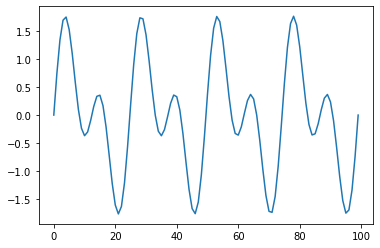

In [45]:
f2 = ifft(fhat)
plt.plot(np.real(f2))
plt.show()

Fourier transforms can reveal a variety of useful information and have many useful properties.  One of which is that convolutions in the time/spatial domain become pointwise multiplication in the frequency domain.

\begin{equation}
h = f \ast g \Leftrightarrow \hat{h} = \hat{f} \hat{g}
\end{equation}

This means that circulant matrices and their inverses can be applied in $O(N \log N)$ time using the FFT.

In [46]:
def apply_circulant(c, x):
    """
    apply circulant matrix with first row c to a vector x
    
    y = C x
    """
    c_hat = fft(c)
    x_hat = fft(x)
    y_hat = c_hat * x_hat
    return ifft(y_hat)

In [48]:
N = 100
c = np.random.randn(N)
A = la.circulant(c)

x = np.random.randn(N)

%time y1 = A @ x
%time y2 = apply_circulant(c, x)

la.norm(y1 - y2)

CPU times: user 39 µs, sys: 0 ns, total: 39 µs
Wall time: 43.9 µs
CPU times: user 434 µs, sys: 0 ns, total: 434 µs
Wall time: 383 µs


3.158782819493711e-14

In [49]:
def apply_circulant_inv(c, x):
    """
    apply inverse of circulant matrix with first row c to a vector x
    
    y = C^{-1} x
    """
    c_hat = fft(c)
    x_hat = fft(x)
    y_hat = x_hat / c_hat
    return ifft(y_hat)

In [50]:
N = 100
c = np.random.randn(N)
A = la.circulant(c)

x = np.random.randn(N)
b = A @ x

%time y1 = la.solve_circulant(c, x)
%time y2 = apply_circulant_inv(c, x)

la.norm(y1 - y2)

CPU times: user 242 µs, sys: 15 µs, total: 257 µs
Wall time: 233 µs
CPU times: user 269 µs, sys: 0 ns, total: 269 µs
Wall time: 255 µs


4.5836491643602516e-15

### Exercise

Create a plot that demonstrates the asymptotic scaling of the FFT is $O(N \log N)$

In [ ]:
## Your code here

## Higher Dimensions

In 2 dimensions, you can use scipy's [`fft2` and `ifft2`](https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html#and-n-d-discrete-fourier-transforms) for 2-dimensional signals such as images.  For an $m \times n$ image, the time complexity is $O(mn \log(mn))$

For general image processing, you may find it useful to install `scikit-image`

```
(pycourse) conda install scikit-image
```


### Sparse Convolutions

In image processing, you may often encounter sparse convolutions, particularly convolutions that are very localized (e.g. only the first few entries of the firs row `c` are nonzero).  One example is that many camera lenses cause a slight blur which mixes light from nearby sources.  In deep learning, these sparse convolutions have been very effective in image processing tasks. Perhaps the simplest explanation of why learning parameters for a convolution is a good idea in this situation is that convolutions are *translation invariant* allowing the neural net to learn regardless of where a target appears on an image.

In this case, we typically think of convolutions as $k\times k$ patches which slide over a 2-dimensional image.  

The time complexity of applying this convolution using standard for-loops to a $m\times n$ image is $O(k^2 mn)$, which is typically faster than using a Fourier transform.  GPUs are also very good at this sort of operation.

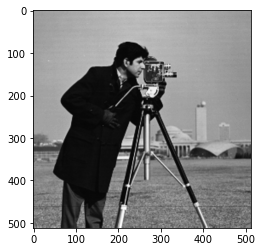

In [64]:
import skimage

img = skimage.data.camera()
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

In [74]:
from numba import njit

@njit
def apply_convolution_2d(img, c):
    m, n = img.shape
    k1, k2 = c.shape
    img2 = np.zeros((m-k1, n-k2))
    for i in range(m-k1):
        for j in range(n-k2):
            for i1 in range(k1):
                for j1 in range(k2):
                    img2[i,j] = img2[i,j] + img[i+i1, j+j1] * c[i1, j1]
    return img2

CPU times: user 38.7 ms, sys: 0 ns, total: 38.7 ms
Wall time: 38.6 ms


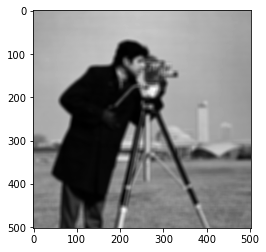

In [88]:
c = np.ones((10,10)) / 100 # local averageing operator
%time img2 = apply_convolution_2d(img, c)

plt.imshow(img2, cmap=plt.cm.gray)
plt.show()

If you're using this sort of convolution in PyTorch, you can use [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) or `torch.conv2d`

In [119]:
import torch

conv = torch.nn.Conv2d(1, 1, (3,3)) # 3 x 3 convolution

In [124]:
c = torch.Tensor(np.ones((1,1,10,10)) / 100)
imgt = torch.Tensor(img).reshape(1,1,*img.shape) # add batch and channel dimension

In [126]:
%time imgt2 = torch.conv2d(imgt, c)

CPU times: user 58.1 ms, sys: 2.77 ms, total: 60.8 ms
Wall time: 15 ms


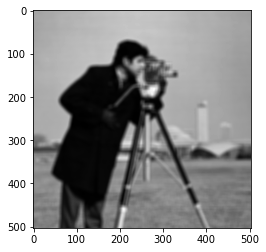

In [135]:
img2 = imgt2.numpy()
img2 = img2[0,0,:,:]

plt.imshow(img2, cmap=plt.cm.gray)
plt.show()

## Discrete Cosine Transform (DCT)

One of the potential annoyances with Fourier transforms is that even with real-valued signals they produce complex output.  If you want to stick to real output with a similar interpretation, you can use the Discrete Cosine Transform (DCT) or Discrete Sine Transform (DST).  Both are implemented in Scipy.

[Scipy DCT](https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html#discrete-cosine-transforms)

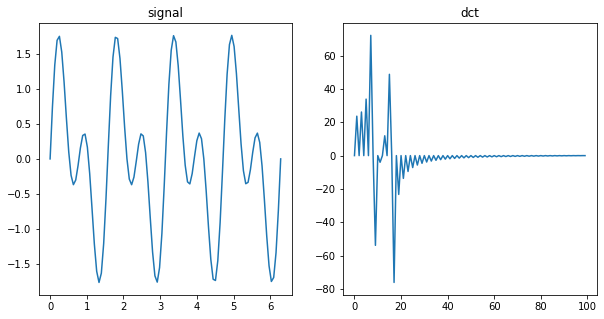

In [17]:
from scipy.fft import dct, idct

x = np.linspace(0, 2*np.pi, 100)
f = np.sin(4*x) + np.sin(8*x)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(x, f)
ax[0].set_title("signal")

fhat = dct(f)
ax[1].plot(fhat)
ax[1].set_title("dct")
plt.show()

In [19]:
?np.linspace

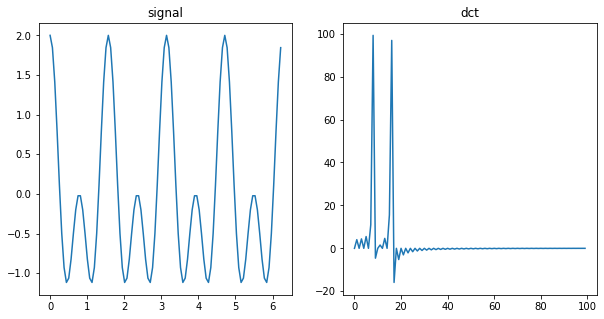

In [20]:
x = np.linspace(0, 2*np.pi, 100, endpoint=False)
f = np.cos(4*x) + np.cos(8*x)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(x, f)
ax[0].set_title("signal")

fhat = dct(f)
ax[1].plot(fhat)
ax[1].set_title("dct")
plt.show()

The DCT is also a simple method of image compression - you can simply remove the high frequency componenents of an image and retain most of the large structure while losing some detail.

In [42]:
from scipy import ndimage
from scipy.fft import dctn, idctn
import skimage

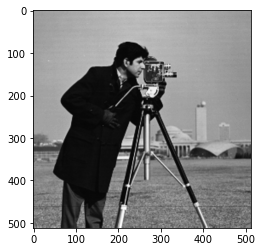

In [32]:
img = skimage.data.camera()
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

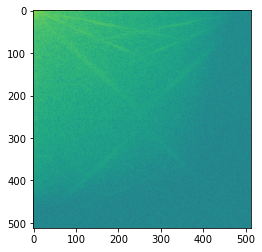

In [37]:
ihat = dctn(img)
plt.imshow(np.log(np.abs(ihat)))
plt.show()

Now, we'll cut out the highest-frequency DCT coefficients.

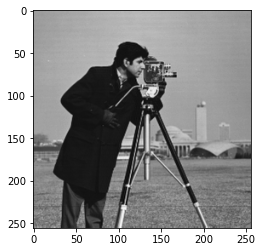

In [43]:
m, n = ihat.shape
ihat2 = ihat[:m//2, :n//2]
img2 = idctn(ihat2)
plt.imshow(img2, cmap=plt.cm.gray)

alternatively, we can make the image the original size by just setting the high-frequency DCT coefficients to 0. 

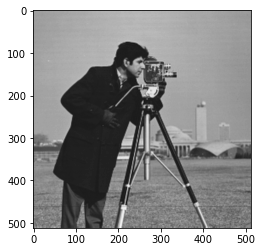

In [56]:
ihat2 = np.zeros_like(ihat)
ihat2[:m//2, :n//2] = ihat[:m//2, :n//2]
img2 = idctn(ihat2)
plt.imshow(img2, cmap=plt.cm.gray)

Now, let's really compress the image...

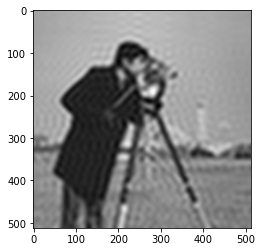

In [59]:
ihat2 = np.zeros_like(ihat)
ihat2[:m//10, :n//10] = ihat[:m//10, :n//10]
img2 = idctn(ihat2)
plt.imshow(img2, cmap=plt.cm.gray)